In [1]:
import os
import json
import requests
import pandas as pd

# Import VADER Dependencies
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gallo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Using The Guardian API to pull in headlines from search

In [2]:
searches = ['American%20Politics','US%20economy', 'US%20stock%20market', 'US%20President','Cryptocurrency%20OR%20Bitcoin%20OR%20Ethereum']
size = 200
dictionary = {'Date': [], 'Category': [], 'Title': []}
for s in searches:
    guardian_url = f"https://content.guardianapis.com/search?q={s}&to-date=2020-12-31&from-date=2020-01-01&order-by=oldest&page-size={size}&api-key=2e00ffe0-1ee3-4914-90b1-b39eb782de0b"
    guardian_response = requests.get(guardian_url)
    guardian_response_json = guardian_response.json()
    list1 = guardian_response_json['response']['results']
    for i, a in enumerate(list1):
        date = list1[i]['webPublicationDate']
        name = list1[i]['webTitle']
        dictionary["Date"].append(date)
        dictionary["Title"].append(name)
        dictionary["Category"].append(s.replace("%20"," "))

In [3]:
clickbait_df = pd.DataFrame(dictionary)
clickbait_df["Date"]= pd.to_datetime(clickbait_df["Date"]) 
clickbait_df.head()

,Date,Category,Title
0,2020-01-01 08:30:00+00:00,American Politics,The final sprint: will any of the Democratic c...
1,2020-01-01 09:01:00+00:00,American Politics,The Power of Bad and How to Overcome It review...
2,2020-01-01 10:00:02+00:00,American Politics,'I'm on the hunt for humour and hope': what wi...
3,2020-01-01 11:15:02+00:00,American Politics,There is no such thing as 'authentic' food. Ig...
4,2020-01-01 16:29:23+00:00,American Politics,Pete Buttigieg fundraising surges amid attacks...


## Using VADER to get sentiment of headlines

In [4]:
# Create a new column to hold sentiment scores
Sentiment = []

for title in clickbait_df["Title"]:
    try:
        text = title
        sentiment = analyzer.polarity_scores(title)
        compound = sentiment["compound"]
        
        Sentiment.append(compound)
        
    except AttributeError:
        pass

sentiment_df = pd.DataFrame(Sentiment)
sentiment_df.columns = ['Compound']
sentiment_df.head()

,Compound
0,0.4767
1,-0.5423
2,0.4767
3,-0.5719
4,-0.4404


In [5]:
combined_df = pd.concat([clickbait_df, sentiment_df], axis="columns", join="inner")
combined_df.set_index('Date', inplace=True)
combined_df["Date Only"] = combined_df.index.date
combined_df.set_index('Date Only', inplace=True)
combined_df.tail()

,Category,Title,Compound
Date Only,,,
2020-12-27,Cryptocurrency OR Bitcoin OR Ethereum,Far-right Israeli football fans rebel over Bei...,-0.1531
2020-12-28,Cryptocurrency OR Bitcoin OR Ethereum,Seabird patrols to self-healing buildings: the...,0.0000
2020-12-30,Cryptocurrency OR Bitcoin OR Ethereum,'I've never seen anything like it': 2020 smash...,-0.2755
2020-12-30,Cryptocurrency OR Bitcoin OR Ethereum,"Bitcoin surges to record $28,500, quadrupling ...",0.3400
2020-12-30,Cryptocurrency OR Bitcoin OR Ethereum,Bitcoin hits record high as US dollar slides –...,0.0000


## Reading in Stock Market data and adjusting the index to be the date, so as to match "combined_df" above

In [6]:
stock_market_df = pd.read_csv('SPY_DJI_RUT.csv', infer_datetime_format=True)
stock_market_df["Date"]= pd.to_datetime(stock_market_df["Date"]) 
stock_market_df.set_index('Date', inplace=True)
stock_market_df["Date Only"] = stock_market_df.index.date
stock_market_df.set_index('Date Only', inplace=True)
stock_market_df = stock_market_df.pct_change()
stock_market_df.dropna()

,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,
2020-01-03,-0.008103,-0.007060,-0.003540
2020-01-06,0.002392,0.003533,0.001439
2020-01-07,-0.004170,-0.002803,-0.002976
2020-01-08,0.005647,0.004902,0.003184
2020-01-09,0.007369,0.006655,0.000842
...,...,...,...
2020-12-23,0.003809,0.000746,0.008654
2020-12-24,0.002325,0.003537,-0.001569
2020-12-28,0.006758,0.008723,-0.003842


In [7]:
# combining the two dataframes into a single dataframe and dropping null values
super_df = combined_df.merge(stock_market_df, left_on=['Date Only'], right_on=['Date Only'], how='right')
super_df = super_df.dropna()
super_df

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-03,American Politics,Impeachment: newly unredacted emails a 'devast...,-0.6486,-0.008103,-0.007060,-0.003540
2020-01-03,American Politics,Who is Qassem Suleimani? Iran farm boy who bec...,0.4754,-0.008103,-0.007060,-0.003540
2020-01-03,American Politics,High fashion: the rise of heels for men,0.0000,-0.008103,-0.007060,-0.003540
2020-01-03,American Politics,Abu Mahdi al-Muhandis: Iraqi killed in US stri...,-0.7184,-0.008103,-0.007060,-0.003540
2020-01-03,American Politics,What drives the ‘moral grandstanding’ that has...,-0.4939,-0.008103,-0.007060,-0.003540
...,...,...,...,...,...,...
2020-12-24,Cryptocurrency OR Bitcoin OR Ethereum,"'What am I about?' Ben Lee takes on QAnon, the...",0.4404,0.002325,0.003537,-0.001569
2020-12-28,Cryptocurrency OR Bitcoin OR Ethereum,Seabird patrols to self-healing buildings: the...,0.0000,0.006758,0.008723,-0.003842
2020-12-30,Cryptocurrency OR Bitcoin OR Ethereum,'I've never seen anything like it': 2020 smash...,-0.2755,0.002436,0.001342,0.010529


In [8]:
american_politics_df = super_df[super_df["Category"]=='American Politics']
american_politics_df.head()

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-03,American Politics,Impeachment: newly unredacted emails a 'devast...,-0.6486,-0.008103,-0.00706,-0.00354
2020-01-03,American Politics,Who is Qassem Suleimani? Iran farm boy who bec...,0.4754,-0.008103,-0.00706,-0.00354
2020-01-03,American Politics,High fashion: the rise of heels for men,0.0000,-0.008103,-0.00706,-0.00354
2020-01-03,American Politics,Abu Mahdi al-Muhandis: Iraqi killed in US stri...,-0.7184,-0.008103,-0.00706,-0.00354
2020-01-03,American Politics,What drives the ‘moral grandstanding’ that has...,-0.4939,-0.008103,-0.00706,-0.00354


In [9]:
us_economy_df = super_df[super_df["Category"]=='US economy']
us_economy_df.head()

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-03,US economy,"Millions spent on 'fake' apprenticeships, says...",0.0000,-0.008103,-0.00706,-0.00354
2020-01-03,US economy,Impeachment: newly unredacted emails a 'devast...,-0.6486,-0.008103,-0.00706,-0.00354
2020-01-03,US economy,Where the bloody hell was he? How Scott Morris...,-0.9118,-0.008103,-0.00706,-0.00354
2020-01-03,US economy,Liberia's miracle oil brings farmers only empt...,0.6808,-0.008103,-0.00706,-0.00354
2020-01-03,US economy,Oil prices spike after US drone strike kills I...,-0.6124,-0.008103,-0.00706,-0.00354


In [10]:
us_stockmarket_df = super_df[super_df["Category"]=='US stock market']
us_stockmarket_df.head()

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-03,US stock market,"UK spent a record £3bn on streaming music, fil...",0.0000,-0.008103,-0.00706,-0.00354
2020-01-03,US stock market,How to Fail by Elizabeth Day review – learning...,-0.7650,-0.008103,-0.00706,-0.00354
2020-01-03,US stock market,Anorexia is the deadliest mental illness. Why ...,-0.2919,-0.008103,-0.00706,-0.00354
2020-01-03,US stock market,Why the Dallas Cowboys opening is the best coa...,0.6369,-0.008103,-0.00706,-0.00354
2020-01-03,US stock market,Oil spikes as US strike on Iran general raises...,-0.6808,-0.008103,-0.00706,-0.00354


In [11]:
us_president_df = super_df[super_df["Category"]=='US President']
us_president_df.head()

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-03,US President,Impeachment: newly unredacted emails a 'devast...,-0.6486,-0.008103,-0.00706,-0.00354
2020-01-03,US President,Who is Qassem Suleimani? Iran farm boy who bec...,0.4754,-0.008103,-0.00706,-0.00354
2020-01-03,US President,Concern over 'viability' of dairy farms and mi...,0.0000,-0.008103,-0.00706,-0.00354
2020-01-03,US President,Julián Castro: progressive champion's exit thi...,0.0000,-0.008103,-0.00706,-0.00354
2020-01-03,US President,John Roberts: justice once labelled a 'disaste...,0.5267,-0.008103,-0.00706,-0.00354


In [12]:
bitcoin_ethereum_df = super_df[super_df["Category"]=='Cryptocurrency OR Bitcoin OR Ethereum']
bitcoin_ethereum_df.head()

,Category,Title,Compound,DOW JONES,S&P 500,RUSSELL 2000
Date Only,,,,,,
2020-01-08,Cryptocurrency OR Bitcoin OR Ethereum,Carlos Ghosn insists he is innocent over fraud...,-0.3400,0.005647,0.004902,0.003184
2020-01-14,Cryptocurrency OR Bitcoin OR Ethereum,Government refuses to release briefings for tr...,0.2263,0.001128,-0.001515,0.003672
2020-01-21,Cryptocurrency OR Bitcoin OR Ethereum,Bank of England to consider adopting cryptocur...,0.0000,-0.005181,-0.002652,-0.008084
2020-01-31,Cryptocurrency OR Bitcoin OR Ethereum,"Devon teenagers sentenced after girl, 15, dies...",0.5859,-0.020909,-0.017706,-0.020725
2020-02-12,Cryptocurrency OR Bitcoin OR Ethereum,"Bitcoin bounces back over $10,000 amid coronav...",0.0000,0.009396,0.006463,0.007076


In [13]:
# Get the shape of the dataframe
super_df.shape

(631, 6)

In [14]:
# Get data information
super_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631 entries, 2020-01-03 to 2020-12-30
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      631 non-null    object 
 1   Title         631 non-null    object 
 2   Compound      631 non-null    float64
 3   DOW JONES     631 non-null    float64
 4   S&P 500       631 non-null    float64
 5   RUSSELL 2000  631 non-null    float64
dtypes: float64(4), object(2)
memory usage: 34.5+ KB


# Creating The Models

In [32]:
# Import Dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Dow Jones Industrial Average Model

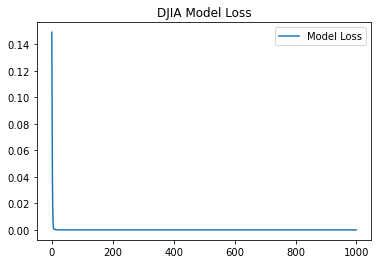

In [47]:
# Create the features (X) and target (y) sets for Dow Jones Industrial Average
DJIA_X = super_df.loc[:, ['Compound']].values
DJIA_y = super_df["DOW JONES"].values

# Scale the data
scaler = StandardScaler().fit(DJIA_X)
DJIA_X = scaler.transform(DJIA_X)

# Define the model - deep neural network with two layers
djia_nn = Sequential()

# First hidden layer
djia_nn.add(Dense(units=8, input_dim=1, activation="relu"))

# Second hidden layer
djia_nn.add(Dense(units=8, activation="sigmoid"))

# Output layer
djia_nn.add(Dense(units=1, activation="linear"))

# Compile the model
djia_nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
djia_model = djia_nn.fit(DJIA_X, DJIA_y, validation_split=0.3, epochs=1000, verbose=0)

# Plotting The Model
plt.plot(djia_model.history["loss"])
plt.title("DJIA Model Loss")
plt.legend(["Model Loss"])
plt.show()

In [50]:
# Export Model
djia_nn.save('djia_model')

INFO:tensorflow:Assets written to: djia_model\assets


### S&P 500 Model

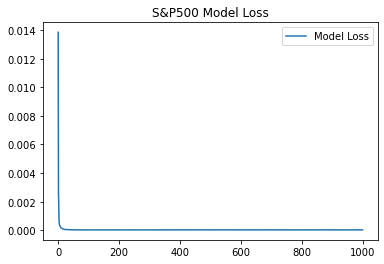

In [48]:
# Create the features (X) and target (y) sets for Dow Jones Industrial Average
SP500_X = super_df.loc[:, ['Compound']].values
SP500_y = super_df["S&P 500"].values

# Scale the data
scaler = StandardScaler().fit(SP500_X)
SP500_X = scaler.transform(SP500_X)

# Define the model - deep neural network with two layers
sp500_nn = Sequential()

# First hidden layer
sp500_nn.add(Dense(units=8, input_dim=1, activation="relu"))

# Second hidden layer
sp500_nn.add(Dense(units=8, activation="sigmoid"))

# Output layer
sp500_nn.add(Dense(units=1, activation="linear"))

# Compile the model
sp500_nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
sp500_model = sp500_nn.fit(DJIA_X, DJIA_y, validation_split=0.3, epochs=1000, verbose=0)

# Plotting The Model
plt.plot(sp500_model.history["loss"])
plt.title("S&P500 Model Loss")
plt.legend(["Model Loss"])
plt.show()

In [51]:
# Export Model
sp500_nn.save('sp500_model')

INFO:tensorflow:Assets written to: sp500_model\assets


### Russell 2000 Model

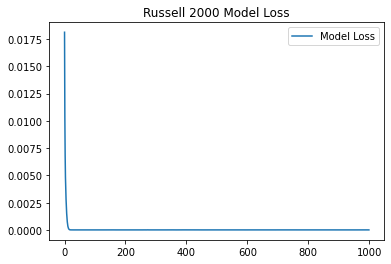

In [49]:
# Create the features (X) and target (y) sets for Dow Jones Industrial Average
R2K_X = super_df.loc[:, ['Compound']].values
R2K_y = super_df["RUSSELL 2000"].values

# Scale the data
scaler = StandardScaler().fit(R2K_X)
R2K_X = scaler.transform(R2K_X)

# Define the model - deep neural network with two layers
r2k_nn = Sequential()

# First hidden layer
r2k_nn.add(Dense(units=8, input_dim=1, activation="relu"))

# Second hidden layer
r2k_nn.add(Dense(units=8, activation="sigmoid"))

# Output layer
r2k_nn.add(Dense(units=1, activation="linear"))

# Compile the model
r2k_nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
r2k_model = r2k_nn.fit(R2K_X, R2K_y, validation_split=0.3, epochs=1000, verbose=0)

# Plotting The Model
plt.plot(r2k_model.history["loss"])
plt.title("Russell 2000 Model Loss")
plt.legend(["Model Loss"])
plt.show()

In [52]:
# Export Model
r2k_nn.save('r2k_model')

INFO:tensorflow:Assets written to: r2k_model\assets
